AUTHOR: MATTEO FOSSATI

NOTEBOOK FOR THE REDUCTION AND ANALYSIS OF TELESCOPE IMAGING SCIENCE




In [1]:
import numpy as np
from astropy.io import fits
import scipy.ndimage as ndi
import matplotlib.pyplot as mp
from google.colab import drive
import glob

mp.rcParams['figure.figsize'] = (15, 10)

In [2]:
drive.mount('/content/drive/', force_remount=True)
path = "/content/drive/My Drive/AI/Codes/Telescope Data/Imaging Science/"

Mounted at /content/drive/


In [3]:
!ls "/content/drive/My Drive/AI/Codes/Telescope Data/Imaging Science/"

calib_001bias.fit    calib_017dark60.fit   flat_003OIII.fit	      NGC956_004Halpha_120s.fit
calib_002bias.fit    calib_018dark60.fit   flat_003SII.fit	      NGC956_005Halpha_300s.fit
calib_003bias.fit    calib_021dark120.fit  flat_004Halpha.fit	      NGC956_006Halpha_300s.fit
calib_004bias.fit    calib_022dark120.fit  flat_004OIII.fit	      NGC956_008OIII_120s.fit
calib_005bias.fit    calib_023dark120.fit  flat_004SII.fit	      NGC956_009OIII_120s.fit
calib_006bias.fit    calib_024dark120.fit  flat_005Halpha.fit	      NGC956_010OIII_300s.fit
calib_007bias.fit    calib_025dark120.fit  flat_005OIII.fit	      NGC956_011OIII_300s.fit
calib_008bias.fit    calib_026dark120.fit  flat_005SII.fit	      NGC956_012SII_120s.fit
calib_011dark60.fit  calib_027dark120.fit  flat_006Halpha.fit	      NGC956_013SII_120s.fit
calib_012dark60.fit  calib_028dark120.fit  flat_006OIII.fit	      NGC956_014SII_300s.fit
calib_013dark60.fit  flat_002Halpha.fit    flat_006SII.fit	      NGC956_015SII_300s.fit
calib_



#Process the Bias and Darks, prepare a dark at 300s by extrapolation

In [ ]:
ccdgain = 0.6 #ADU/e-

In [ ]:
files = glob.glob(path+'calib*bias*')
Nfiles = len(files)
print('Number of frames:{}'.format(Nfiles))

hdu = fits.open(files[0])
bias0 = hdu[0].data
hdu.close()

ny, nx = np.shape(bias0)

allbias = np.zeros((Nfiles,ny,nx))

for ind, ff in enumerate(files):
  hdu = fits.open(ff)
  allbias[ind,...] = hdu[0].data
  hdu.close()

masterbias = np.median(allbias, axis=0)
del allbias

Number of frames:8


In [ ]:
files = glob.glob(path+'calib*dark*60*')
Nfiles = len(files)
print('Number of frames:{}'.format(Nfiles))

#Here stack the 60s darks

Number of frames:8


In [ ]:
files = glob.glob(path+'calib*dark*120*')
Nfiles = len(files)
print('Number of frames:{}'.format(Nfiles))


#Here stack the 120s darks

Number of frames:8


In [ ]:
#Generate a 300s dark by extrapolation, how do we do this?
masterdark_120
masterbias
masterdark_300 = (masterdark_120 - masterbias)*120/300 + masterbias

#Now Stack the Flat frames after having removed the bias (flats are short exposures so the dark current is negligible, what CCD calibration should I subtract?)

In [ ]:
files = glob.glob(path+'flat*Halpha*')
Nfiles = len(files)
print('Number of frames:{}'.format(Nfiles))

#Here generate the Master Flat in Halpha filter



Number of frames:5


(Optional) Repeat for the other filters if you choose this as your exam project



#Now Process the science exposures individually (be careful they have different exposure times)

In [ ]:
num = ['001','002','003','004','005','006']
exptime = [60,60,120,120,300,300]
Nscience = len(num)

In [ ]:
filefmt = path+'NGC956_{}Halpha_{}s.fit'

halpha_reduced = np.zeros((Nscience,ny,nx))

for ind, nn in enumerate(num):
  if exptime ==60:
    dark = masterdark60
  elif exptime ==120:
    dark = masterdark120
  else:
    dark = masterdark300

  hdu = fits.open(filefmt.format(num[ind],exptime[ind]))
  #By dividing by ccd gain and exptime the final units are e-/s
  halpha_reduced[ind,...] #Place here the appropriate formula
  hdu.close()

NameError: name 'masterdark300' is not defined

#Now run a rough co-add of the frames (use mean to preserve SNR properties). Frames must be inverse variance weighted. How does the variance scale with exptime?

In [ ]:
halpha_coadd = np.average(halpha_reduced, weights=1./np.array(exptime), axis=0)
#hdu = fits.PrimaryHDU(halpha_coadd)
#hdu.writeto(path+'COADD1.fits', overwrite=True)

In [ ]:
mp.imshow(halpha_coadd,vmin=10, vmax=50, origin='lower')
mp.ylim(2000,2080)
mp.xlim(2090,2170)

#Stars have moved significantly between different exposures, thus we need to register the individual exposures before the co-add. This can be done by locking onto one star and fitting its profile in order to find its centroid. With centroids in hand you can shift the images such that the star will be in the same physical position and then co-add again.

In [ ]:
!pip install photutils
!pip install sep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import photutils.centroids as cent

In [ ]:
xcent = []
ycent = []

for i in range(Nscience):
  xycent = cent.centroid_quadratic(halpha_reduced[i,2010:2050,2110:2150])
  xcent.append(xycent[0]+2110)
  ycent.append(xycent[1]+2010)

xcent = np.array(xcent)
ycent = np.array(ycent)

xoff = xcent[0]-xcent
yoff = ycent[0]-ycent

In [ ]:
xoff, yoff

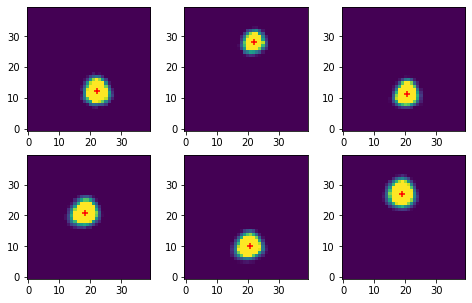

In [ ]:
fig, axes = mp.subplots(nrows=2, ncols=3, figsize=(8,5))
for ind, ax in enumerate(axes.flat):
    try:
      ax.imshow(halpha_reduced[ind,2010:2050,2110:2150],vmin=10, vmax=50, origin='lower')
      ax.scatter([xcent[ind]-2110],[ycent[ind]-2010], marker='+', color='red')
    except:
      pass

In [ ]:
#Now position the images
for i in range(1,Nscience):
  halpha_reduced[i,...] = ndi.shift(halpha_reduced[i,...], (yoff[i],xoff[i]))

Interpolating the data with splines can lead to artifacts as splines can overshoot the data, you can try np.roll to shift the data. Roll does not interpolate the input but you are limited to integer pixel shifts

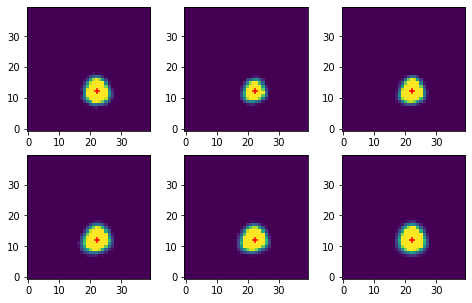

In [ ]:
fig, axes = mp.subplots(nrows=2, ncols=3, figsize=(8,5))
for ind, ax in enumerate(axes.flat):
    try:
      ax.imshow(halpha_reduced[ind,2010:2050,2110:2150],vmin=10, vmax=50, origin='lower')
      ax.scatter([xcent[0]-2110],[ycent[0]-2010], marker='+', color='red')
    except:
      pass

In [ ]:
#Coadd again the images

#ADD YOUR COADDING CODE HERE

In [ ]:
mp.imshow(halpha_coadd,vmin=-1, vmax=5, origin='lower')
mp.ylim(1000,2000)
mp.xlim(1500,2500)

We now measure the flux in one of the *stars*



In [ ]:
from photutils.aperture import aperture_photometry, CircularAnnulus, CircularAperture, ApertureStats
from astropy.visualization import simple_norm


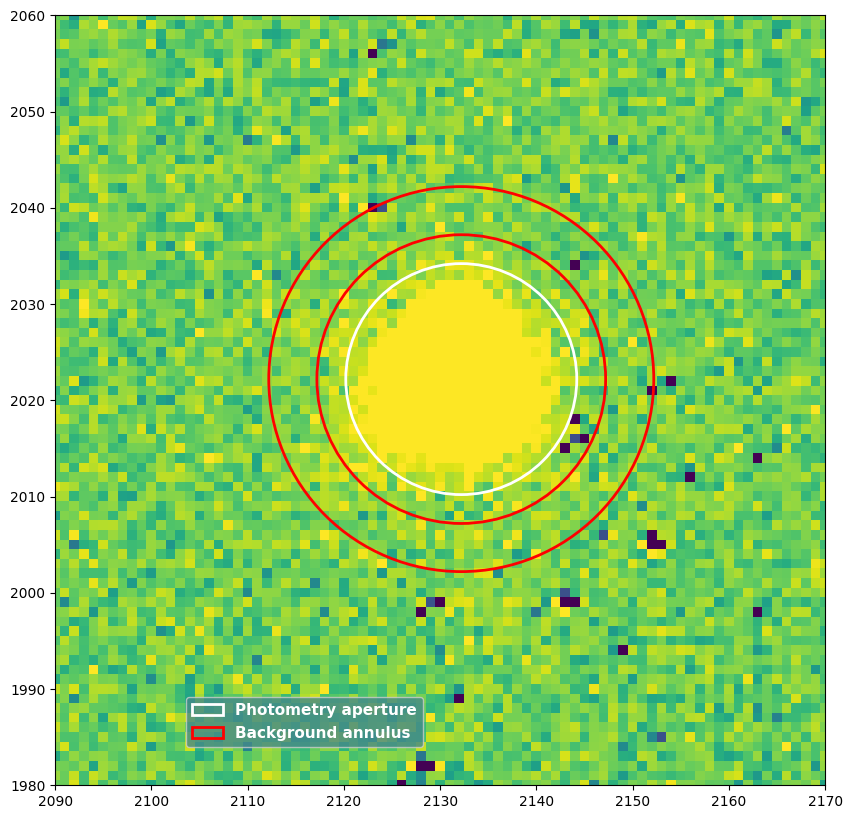

In [ ]:
#Define the source position and prepare a simple plot to identify the regions for data and background
positions = [(2132.2,2022.2)]
aperture = CircularAperture(positions, r=12)
annulus_aperture = CircularAnnulus(positions, r_in=15, r_out=20)

norm = simple_norm(halpha_coadd, 'sqrt', percent=99)
mp.imshow(halpha_coadd, norm=norm, interpolation='nearest')
mp.ylim(1980,2060)
mp.xlim(2090,2170)

ap_patches = aperture.plot(color='white', lw=2,label='Photometry aperture')
ann_patches = annulus_aperture.plot(color='red', lw=2,label='Background annulus')

handles = (ap_patches[0], ann_patches[0])
mp.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})


In [ ]:
phot = aperture_photometry(halpha_coadd, aperture)

 id xcenter ycenter    aperture_sum  
      pix     pix                    
--- ------- ------- -----------------
  1  2132.2  2022.2 5694.103395370246


Text(0.5, 0, 'Radius')

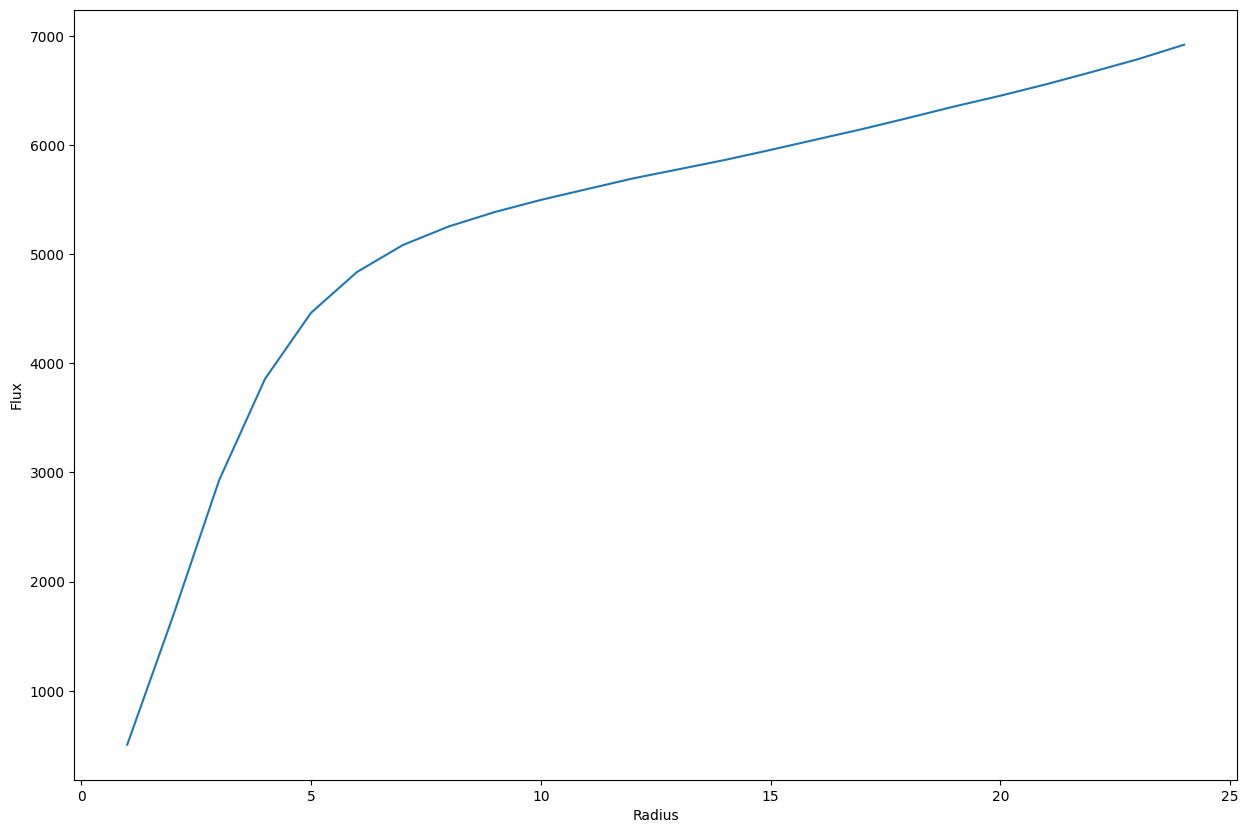

In [ ]:
apflux = []

for i in np.arange(1,25):
  aperture = CircularAperture(positions, r=i)
  apflux.append(aperture_photometry(halpha_coadd, aperture)['aperture_sum'])

mp.plot(np.arange(1,25), apflux)
mp.ylabel('Flux')
mp.xlabel('Radius')

#Is this what you can naively expect from the image above? If not, what could be wrong?

# The flux keeps increasing with the aperture radius, but it should be constant. The background is not being subtracted.
# The backgroud contibutes to the flux, we should decrease the aperture radius to avoid accounting for the background.

In [ ]:
from astropy.stats import SigmaClip

#Redefine apertures for convenience
aperture = CircularAperture(positions, r=12)
annulus_aperture = CircularAnnulus(positions, r_in=15, r_out=20)

#Define a clipping scheme
sigclip = SigmaClip(sigma=3.0, maxiters=10)

#Do the photometry
aper_stats = ApertureStats(halpha_coadd, aperture, sigma_clip=None)
bkg_stats = ApertureStats(halpha_coadd, annulus_aperture, sigma_clip=sigclip)

In [ ]:
#This mean is for one pixel
print(bkg_stats.mean)

[0.94243488]


In [ ]:
#This value is over N pixels
print(aper_stats.sum)

[5694.10339537]


In [ ]:
#The background needs to be scaled to the right number of pixels
total_bkg = bkg_stats.mean * aper_stats.sum_aper_area.value

print(aper_stats.sum - total_bkg)

[5267.75590203]


Text(0.5, 0, 'Radius')

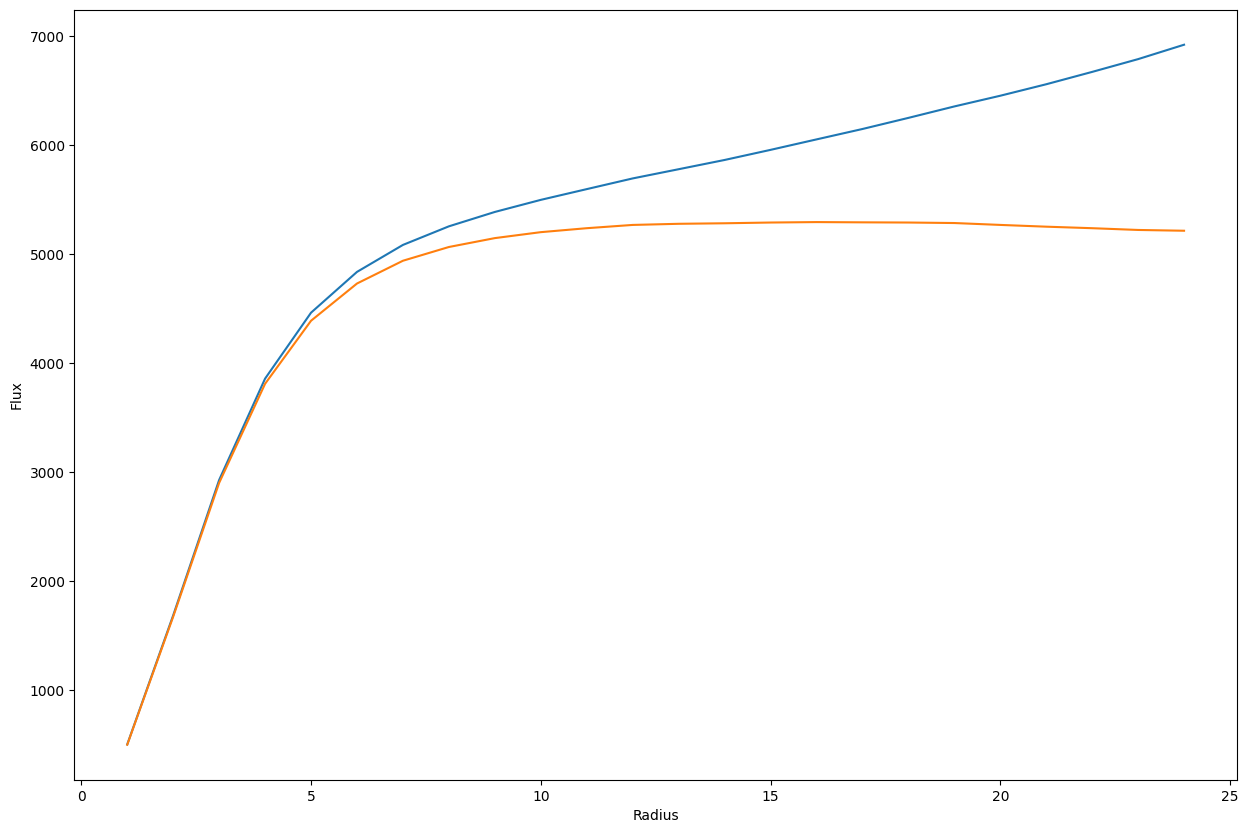

In [ ]:
apflux = []
apflux_bkg = []

for i in np.arange(1,25):
  aperture = CircularAperture(positions, r=i)
  apflux.append(aperture_photometry(halpha_coadd, aperture)['aperture_sum'])
  apflux_bkg.append(aperture_photometry(halpha_coadd, aperture)['aperture_sum']-bkg_stats.mean * aperture.area)

mp.plot(np.arange(1,25), apflux)
mp.plot(np.arange(1,25), apflux_bkg)
mp.ylabel('Flux')
mp.xlabel('Radius')

#Which of these two lines do you find to be more correct?

# Fluxes with background subtraction are more correct.